<a href="https://colab.research.google.com/github/SvenTern/algotrade/blob/main/finrl_main_part.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Управление портфелем акций SP500***
#Нужно написать короткий пример :
#Взять простой набор акций из 30.
#Взять минутный интервал. Загрузить данные, сохранить в Google disk.
#Период взять 1 месяца.
#Взять предел 2% входа по каждой акции
#Сделать трейнинг оптимизации портфеля, чтобы было 5 акций, с лимитом 20%
#Но нужно сделать оптимизацию, и на short-long


# Содержание

* [1. Описание задачи](#0)
* [2. Установка инструментов](#1)
    * [2.1. Установка пакетов](#1.1)    
    * [2.2. Список пакетов Python](#1.2)
    * [2.3. Импорт пакетов](#1.3)
    * [2.4. Создание папок](#1.4)
* [3. Загрузка данных](#2)
* [4. Предварительная обработка данных](#3)        
    * [4.1 Импорт финансовых данных](#3.1)
    * [4.2 Указание необходимых элементов для расчета финансовых показателей](#3.2)
    * [4.3 Расчет финансовых показателей](#3.3)
    * [4.4 Обработка пропущенных и некорректных значений](#3.4)
    * [4.5 Объединение данных о ценах акций и показателей в один DataFrame](#3.5)
    * [4.6 Расчет рыночных коэффициентов оценки с использованием ежедневных данных о ценах акций](#3.6)
* [5. Создание среды](#4)  
    * [5.1. Разделение данных на тренировочные и тестовые](#4.1)
    * [5.2. Пользовательская среда](#4.2)   
    * [5.3. Инициализация среды](#4.3)    
* [6. Обучение агентов DRL](#5)  
* [7. Оценка производительности методом обратного тестирования](#6)  
    * [7.1. Статистика обратного тестирования](#6.1)
    * [7.2. График обратного тестирования](#6.2)   
    * [7.3. Базовая статистика](#6.3)   
    * [7.4. Сравнение с индексом фондового рынка](#6.4)  

<a id='0'></a>
# Часть 1. Описание задачи

Мы будем обучать агента (Deep Reinforcement Learning - DRL) торговле акциями. Задача описывается как Марковский процесс принятия решений (MDP), и целевая функция состоит в максимизации (ожидаемой) накопленной доходности.

Определяем состояние-действие-награду следующим образом:

* **Состояние $s$**: Пространство состояний представляет собой восприятие агентом среды рынка. Какё трейдер-человек анализирует различную информацию, так и наш агент пассивно наблюдает множество признаков и учится взаимодействуя с рыночной средой (обычно путем воспроизведения исторических данных).

* **Действие $a$**: Пространство действий включает разрешенные действия, которые агент может совершать в каждом состоянии. Например, $a \in {−1, 0, 1}$, где $−1, 0, 1$ представляют продажу, удержание и покупку. Когда действие касается нескольких акций, то $a \in {−k, ..., −1, 0, 1, ..., k}$, например, "Покупка 10 акций AAPL" или "Продажа 10 акций AAPL" - это 10 или −10 соответственно.

* **Функция вознаграждения $r(s, a, s′)$**: Вознаграждение является стимулом для агента для изучения лучшей стратегии. Например, это может быть изменение стоимости портфеля при выполнении действия $a$ в состоянии $s$ и переходе в новое состояние $s'$, т.е. $r(s, a, s′) = v′ − v$, где $v′$ и $v$ представляют значения портфеля в состояниях $s'$ и $s$ соответственно.

**Рыночная среда**: 30 акций, составляющих индекс Dow Jones Industrial Average (DJIA).

Данные по отдельной акции, которые мы будем использовать для этого примера, получены из API Yahoo Finance. Данные содержат цены открытия, максимальные, минимальные и закрытия, а также объем торгов.

<a id='1'></a>
# Часть 2. Загрузка пакетов

<a id='1.1'></a>
## 2.1. Установка FinRL


In [5]:
## install finrl library
!pip install wrds
!pip install swig
!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
!pip install mplfinance

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/site-packages/condacolab.py:315: DeprecationWarning: Use shutil.which instead of find_executable
  assert find_executable("conda"), "💥💔💥 Conda not found!"


✨🍰✨ Everything looks OK!
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-iofzlpyw
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-iofzlpyw
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 083192a2abbdcaa195bd945b35853212cd8b00d8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-x9c3r90q/elegantrl_a6493a70fcb7426da12f01a00b68a83a
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-x9c3r90q/elegantrl_a6493a70fcb7426da12f01a00b68a



<a id='1.2'></a>
## 2.2. Перечень пакетов, которые мы будем использовать в данной работе
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* pyfolio

<a id='1.3'></a>
## 2.3. Импортируем библиотеки

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import datetime
from os.path import exists

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from finrl import config
from finrl import config_tickers
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from finrl.main import check_and_make_directories
from pprint import pprint
from stable_baselines3.common.logger import configure
import sys
# sys.path.append("../FinRL")

import pickle

import itertools

from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

from finrl.config_tickers import SP_500_TICKER, DOW_30_TICKER

from google.colab import drive
import os

# Подключение Google Диска
drive.mount('/content/drive')

/usr/local/lib/python3.10/site-packages/pandas_datareader/compat/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)


Mounted at /content/drive


<a id='1.4'></a>
## 2.4. Создаем служебные папки

In [3]:
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<a id='2'></a>
# Часть 3. Скачиваем данные с Yahoo Finance
Yahoo Finance предоставляет данные о акциях, финансовые новости, финансовые отчеты и т.д. Yahoo Finance бесплатен.
* FinRL использует класс `YahooDownloader` в `FinRL-Meta` для получения данных через API Yahoo Finance.
* Ограничение вызова: Используя общедоступное API (без аутентификации), вы ограничены 2 000 запросами в час на IP (или до общего количества 48 000 запросов в день).




-----
class YahooDownloader:
    Получение ежедневных данных о акциях из API Yahoo Finance

    Attributes
    ----------
        start_date : str
            начальная дата (можно изменить в файле config.py)
        end_date : str
            конечная дата (можно изменить в файле config.py)
        ticker_list : list
            список акций, которые вы хотите извлечь (можно изменить в файле config.py)

    Methods
    -------
    fetch_data()

In [83]:
"""Reference: https://github.com/AI4Finance-LLC/FinRL"""

from __future__ import annotations

import datetime
from datetime import date
from datetime import timedelta
from sqlite3 import Timestamp
from typing import Any
from typing import Dict
from typing import List
from typing import Optional
from typing import Type
from typing import TypeVar
from typing import Union

import exchange_calendars as tc
import numpy as np
import pandas as pd
import pytz
import yfinance as yf
import mplfinance as mpf
from stockstats import StockDataFrame as Sdf


class YahooFinanceProcessor:
    """Provides methods for retrieving daily stock data from
    Yahoo Finance API
    """

    def __init__(self, start_date : str = None, end_date : str = None, ticker_list : list[str] = None, time_interval : str = "1d", file_path:str = None, proxy: str | dict = None):
        self.ticker_list = ticker_list
        self.start = start_date
        self.end = end_date
        self.time_interval = self.convert_interval(time_interval)
        self.proxy = proxy
        folder_path = '/content/drive/My Drive/DataTrading'
        os.makedirs(folder_path, exist_ok=True)
        self.file_path = os.path.join(folder_path, file_path)
        self.clean = False

    """
    Param
    ----------
        start_date : str
            start date of the data
        end_date : str
            end date of the data
        ticker_list : list
            a list of stock tickers
    Example
    -------
    input:
    ticker_list = config_tickers.DOW_30_TICKER
    start_date = '2009-01-01'
    end_date = '2021-10-31'
    time_interval == "1D"

    output:
        date	    tic	    open	    high	    low	        close	    volume
    0	2009-01-02	AAPL	3.067143	3.251429	3.041429	2.767330	746015200.0
    1	2009-01-02	AMGN	58.590000	59.080002	57.750000	44.523766	6547900.0
    2	2009-01-02	AXP	    18.570000	19.520000	18.400000	15.477426	10955700.0
    3	2009-01-02	BA	    42.799999	45.560001	42.779999	33.941093	7010200.0
    ...
    """

    def convert_interval(self, time_interval: str) -> str:
        # Convert FinRL 'standardised' time periods to Yahoo format: 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo
        if time_interval in [
            "1Min",
            "2Min",
            "5Min",
            "15Min",
            "30Min",
            "60Min",
            "90Min",
        ]:
            time_interval = time_interval.replace("Min", "m")
        elif time_interval in ["1H", "1D", "5D", "1h", "1d", "5d"]:
            time_interval = time_interval.lower()
        elif time_interval == "1W":
            time_interval = "1wk"
        elif time_interval in ["1M", "3M"]:
            time_interval = time_interval.replace("M", "mo")
        else:
            raise ValueError("wrong time_interval")

        return time_interval

    def download_data(
        self, download_from_disk : bool = False, clean_data : bool = False
    ) -> pd.DataFrame:
        if clean_data:
            self.clean = True
        if download_from_disk:
          return pd.read_csv(self.file_path + '.csv')

        # Download and save the data in a pandas DataFrame
        start_date = pd.Timestamp(self.start)
        end_date = pd.Timestamp(self.end)
        delta = timedelta(days=1)
        data_df = pd.DataFrame()
        for tic in self.ticker_list:
            current_tic_start_date = start_date
            while (
                current_tic_start_date <= end_date
            ):  # downloading daily to workaround yfinance only allowing  max 7 calendar (not trading) days of 1 min data per single download
                temp_df = yf.download(
                    tic,
                    start=current_tic_start_date,
                    end=current_tic_start_date + delta,
                    interval=self.time_interval,
                    proxy=self.proxy,
                )
                temp_df = temp_df.reset_index()
                temp_df.columns = [
                  "timestamp",
                  "adjclose",
                  "close",
                  "high",
                  "low",
                  "open",
                  "volume"]
                temp_df["tic"] = tic

                data_df = pd.concat([data_df, temp_df])
                current_tic_start_date += delta

        data_df["close"] = data_df["adjclose"]
        data_df = data_df.reset_index(drop=True).drop(columns=["adjclose"])
        df.to_csv(self.file_path + '.csv', index=False)
        return data_df

    def convert_local_time(self, local_time, time_zone):
      # Check if the local_time is str
      if type(local_time) == str:
        local_time = pd.Timestamp(local_time)
      # Check if the timestamp is already tz-aware
      if local_time.tz is not None:
        # If tz-aware, convert to desired timezone using tz_convert
        return local_time.tz_convert(time_zone)
      else:
        # If tz-naive, localize to desired timezone using tz_localize
        return local_time.tz_localize(time_zone)


    def clean_data(self, df: pd.DataFrame) -> pd.DataFrame:
        if self.clean:
            return pd.read_csv(self.file_path + '_clean.csv')
        tic_list = np.unique(df.tic.values)
        NY = "America/New_York"

        trading_days = self.get_trading_days()
        # produce full timestamp index
        if self.time_interval == "1d":
            times = trading_days
        elif self.time_interval == "1m":
            times = []
            for day in trading_days:
                current_time = self.convert_local_time(pd.Timestamp(day + " 09:30:00"), NY)
                for i in range(390):  # 390 minutes in trading day
                    times.append(current_time)
                    current_time += pd.Timedelta(minutes=1)
        else:
            raise ValueError(
                "Data clean at given time interval is not supported for YahooFinance data."
            )
        # create a new dataframe with full timestamp series
        print('Cleaning data, recheck for nan, recheck for empty start/end date replacing for previous/next data')
        new_df = pd.DataFrame()
        for tic in tic_list:
            tmp_df = pd.DataFrame(
                columns=["open", "high", "low", "close", "volume"], index=times
            )
            tic_df = df[
                df.tic == tic
            ]  # extract just the rows from downloaded data relating to this tic
            for i in range(tic_df.shape[0]):  # fill empty DataFrame using original data
                #tmp_df.loc[self.convert_local_time(tic_df.iloc[i]["timestamp"], NY)] = tic_df.iloc[i][["open", "high", "low", "close", "volume"]]
                tmp_df.loc[times[i]] = tic_df.iloc[i][["open", "high", "low", "close", "volume"]]
            # print("(9) tmp_df\n", tmp_df.to_string()) # print ALL dataframe to check for missing rows from download

            # if close on start date is NaN, fill data with first valid close
            # and set volume to 0.
            if str(tmp_df.iloc[0]["close"]) == "nan":
                print("NaN data on start date, fill using first valid data.")
                for i in range(tmp_df.shape[0]):
                    if str(tmp_df.iloc[i]["close"]) != "nan":
                        first_valid_close = tmp_df.iloc[i]["close"]
                        tmp_df.iloc[0] = [
                            first_valid_close,
                            first_valid_close,
                            first_valid_close,
                            first_valid_close,
                            0.0,
                        ]
                        break

            # if the close price of the first row is still NaN (All the prices are NaN in this case)
            if str(tmp_df.iloc[0]["close"]) == "nan":
                print(
                    "Missing data for ticker: ",
                    tic,
                    " . The prices are all NaN. Fill with 0.",
                )
                tmp_df.iloc[0] = [
                    0.0,
                    0.0,
                    0.0,
                    0.0,
                    0.0,
                ]

            # fill NaN data with previous close and set volume to 0.
            for i in range(tmp_df.shape[0]):
                if str(tmp_df.iloc[i]["close"]) == "nan":
                    previous_close = tmp_df.iloc[i - 1]["close"]
                    if str(previous_close) == "nan":
                        raise ValueError
                    tmp_df.iloc[i] = [
                        previous_close,
                        previous_close,
                        previous_close,
                        previous_close,
                        0.0,
                    ]
                    # print(tmp_df.iloc[i], " Filled NaN data with previous close and set volume to 0. ticker: ", tic)

            # merge single ticker data to new DataFrame
            tmp_df = tmp_df.astype(float)
            tmp_df["tic"] = tic
            new_df = pd.concat([new_df, tmp_df])

            print(("Data clean for ") + tic + (" is finished."))

        # reset index and rename columns
        new_df = new_df.reset_index()
        new_df = new_df.rename(columns={"index": "date"})

        new_df.sort_values(['date','tic'],ignore_index=True)
        #        print("Data clean all finished!")
        new_df.to_csv(self.file_path+ '_clean.csv', index=False)
        self.clean = True
        return new_df

    def add_technical_indicator(
        self, data: pd.DataFrame, tech_indicator_list: list[str]
    ):
        """
        calculate technical indicators
        use stockstats package to add technical inidactors
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        df = df.sort_values(by=["tic", "timestamp"])
        stock = Sdf.retype(df.copy())
        unique_ticker = stock.tic.unique()

        for indicator in tech_indicator_list:
            indicator_df = pd.DataFrame()
            for i in range(len(unique_ticker)):
                try:
                    temp_indicator = stock[stock.tic == unique_ticker[i]][indicator]
                    temp_indicator = pd.DataFrame(temp_indicator)
                    temp_indicator["tic"] = unique_ticker[i]
                    temp_indicator["timestamp"] = df[df.tic == unique_ticker[i]][
                        "timestamp"
                    ].to_list()
                    indicator_df = pd.concat(
                        [indicator_df, temp_indicator], ignore_index=True
                    )
                except Exception as e:
                    print(e)
            df = df.merge(
                indicator_df[["tic", "timestamp", indicator]],
                on=["tic", "timestamp"],
                how="left",
            )
        df = df.sort_values(by=["timestamp", "tic"])
        return df

    def add_vix(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        add vix from yahoo finance
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        vix_df = self.download_data(["VIXY"], self.start, self.end, self.time_interval)
        cleaned_vix = self.clean_data(vix_df)
        print("cleaned_vix\n", cleaned_vix)
        vix = cleaned_vix[["timestamp", "close"]]
        print('cleaned_vix[["timestamp", "close"]\n', vix)
        vix = vix.rename(columns={"close": "VIXY"})
        print('vix.rename(columns={"close": "VIXY"}\n', vix)

        df = data.copy()
        print("df\n", df)
        df = df.merge(vix, on="timestamp")
        df = df.sort_values(["timestamp", "tic"]).reset_index(drop=True)
        return df

    def calculate_turbulence(
        self, data: pd.DataFrame, time_period: int = 252
    ) -> pd.DataFrame:
        # can add other market assets
        df = data.copy()
        df_price_pivot = df.pivot(index="timestamp", columns="tic", values="close")
        # use returns to calculate turbulence
        df_price_pivot = df_price_pivot.pct_change()

        unique_date = df.timestamp.unique()
        # start after a fixed timestamp period
        start = time_period
        turbulence_index = [0] * start
        # turbulence_index = [0]
        count = 0
        for i in range(start, len(unique_date)):
            current_price = df_price_pivot[df_price_pivot.index == unique_date[i]]
            # use one year rolling window to calcualte covariance
            hist_price = df_price_pivot[
                (df_price_pivot.index < unique_date[i])
                & (df_price_pivot.index >= unique_date[i - time_period])
            ]
            # Drop tickers which has number missing values more than the "oldest" ticker
            filtered_hist_price = hist_price.iloc[
                hist_price.isna().sum().min() :
            ].dropna(axis=1)

            cov_temp = filtered_hist_price.cov()
            current_temp = current_price[[x for x in filtered_hist_price]] - np.mean(
                filtered_hist_price, axis=0
            )
            temp = current_temp.values.dot(np.linalg.pinv(cov_temp)).dot(
                current_temp.values.T
            )
            if temp > 0:
                count += 1
                if count > 2:
                    turbulence_temp = temp[0][0]
                else:
                    # avoid large outlier because of the calculation just begins
                    turbulence_temp = 0
            else:
                turbulence_temp = 0
            turbulence_index.append(turbulence_temp)

        turbulence_index = pd.DataFrame(
            {"timestamp": df_price_pivot.index, "turbulence": turbulence_index}
        )
        return turbulence_index

    def add_turbulence(
        self, data: pd.DataFrame, time_period: int = 252
    ) -> pd.DataFrame:
        """
        add turbulence index from a precalcualted dataframe
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        turbulence_index = self.calculate_turbulence(df, time_period=time_period)
        df = df.merge(turbulence_index, on="timestamp")
        df = df.sort_values(["timestamp", "tic"]).reset_index(drop=True)
        return df

    def df_to_array(
        self, df: pd.DataFrame, tech_indicator_list: list[str], if_vix: bool
    ) -> list[np.ndarray]:
        df = df.copy()
        unique_ticker = df.tic.unique()
        if_first_time = True
        for tic in unique_ticker:
            if if_first_time:
                price_array = df[df.tic == tic][["close"]].values
                tech_array = df[df.tic == tic][tech_indicator_list].values
                if if_vix:
                    turbulence_array = df[df.tic == tic]["VIXY"].values
                else:
                    turbulence_array = df[df.tic == tic]["turbulence"].values
                if_first_time = False
            else:
                price_array = np.hstack(
                    [price_array, df[df.tic == tic][["close"]].values]
                )
                tech_array = np.hstack(
                    [tech_array, df[df.tic == tic][tech_indicator_list].values]
                )
        #        print("Successfully transformed into array")
        return price_array, tech_array, turbulence_array

    def get_trading_days(self) -> list[str]:
        nyse = tc.get_calendar("NYSE")
        df = nyse.sessions_in_range(pd.Timestamp(self.start), pd.Timestamp(self.end))
        trading_days = []
        for day in df:
            trading_days.append(str(day)[:10])

        return trading_days

    # ****** NB: YAHOO FINANCE DATA MAY BE IN REAL-TIME OR DELAYED BY 15 MINUTES OR MORE, DEPENDING ON THE EXCHANGE ******
    def fetch_latest_data(
        self,
        tech_indicator_list: list[str],
        limit: int = 100,
    ) -> pd.DataFrame:
        time_interval = self.convert_interval(time_interval)

        end_datetime = datetime.datetime.now()
        start_datetime = end_datetime - datetime.timedelta(
            minutes=limit + 1
        )  # get the last rows up to limit

        data_df = pd.DataFrame()
        for tic in self.ticker_list:
            barset = yf.download(
                tic, start_datetime, end_datetime, interval=time_interval
            )  # use start and end datetime to simulate the limit parameter
            barset["tic"] = tic
            data_df = pd.concat([data_df, barset])

        data_df = data_df.reset_index().drop(
            columns=["Adj Close"]
        )  # Alpaca data does not have 'Adj Close'

        data_df.columns = [  # convert to Alpaca column names lowercase
            "timestamp",
            "open",
            "high",
            "low",
            "close",
            "volume",
            "tic",
        ]

        start_time = data_df.timestamp.min()
        end_time = data_df.timestamp.max()
        times = []
        current_time = start_time
        end = end_time + pd.Timedelta(minutes=1)
        while current_time != end:
            times.append(current_time)
            current_time += pd.Timedelta(minutes=1)

        df = data_df.copy()
        new_df = pd.DataFrame()
        for tic in ticker_list:
            tmp_df = pd.DataFrame(
                columns=["open", "high", "low", "close", "volume"], index=times
            )
            tic_df = df[df.tic == tic]
            for i in range(tic_df.shape[0]):
                tmp_df.loc[tic_df.iloc[i]["timestamp"]] = tic_df.iloc[i][
                    ["open", "high", "low", "close", "volume"]
                ]

                if str(tmp_df.iloc[0]["close"]) == "nan":
                    for i in range(tmp_df.shape[0]):
                        if str(tmp_df.iloc[i]["close"]) != "nan":
                            first_valid_close = tmp_df.iloc[i]["close"]
                            tmp_df.iloc[0] = [
                                first_valid_close,
                                first_valid_close,
                                first_valid_close,
                                first_valid_close,
                                0.0,
                            ]
                            break
                if str(tmp_df.iloc[0]["close"]) == "nan":
                    print(
                        "Missing data for ticker: ",
                        tic,
                        " . The prices are all NaN. Fill with 0.",
                    )
                    tmp_df.iloc[0] = [
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                    ]

            for i in range(tmp_df.shape[0]):
                if str(tmp_df.iloc[i]["close"]) == "nan":
                    previous_close = tmp_df.iloc[i - 1]["close"]
                    if str(previous_close) == "nan":
                        previous_close = 0.0
                    tmp_df.iloc[i] = [
                        previous_close,
                        previous_close,
                        previous_close,
                        previous_close,
                        0.0,
                    ]
            tmp_df = tmp_df.astype(float)
            tmp_df["tic"] = tic
            new_df = pd.concat([new_df, tmp_df])

        new_df = new_df.reset_index()
        new_df = new_df.rename(columns={"index": "timestamp"})

        df = self.add_technical_indicator(new_df, tech_indicator_list)
        df["VIXY"] = 0

        price_array, tech_array, turbulence_array = self.df_to_array(
            df, tech_indicator_list, if_vix=True
        )
        latest_price = price_array[-1]
        latest_tech = tech_array[-1]
        start_datetime = end_datetime - datetime.timedelta(minutes=1)
        turb_df = yf.download("VIXY", start_datetime, limit=1)
        latest_turb = turb_df["Close"].values
        return latest_price, latest_tech, latest_turb

    def candle_plot(self, df: pd.DataFrame, tic: str = 'AAPL', style: str = 'yahoo', interval: str = '1T'):
        """
        Построение свечного графика с возможностью задания интервала.

        :param df: DataFrame с данными
        :param tic: Тикер (символ акции)
        :param style: Стиль графика mplfinance
        :param interval: Интервал для ресемплинга ('1T' - 1 минута, '5T' - 5 минут и т.д.)
        """
        # Проверка на наличие необходимых колонок
        required_columns = {"open", "high", "low", "close", "volume", "tic"}
        if not required_columns.issubset(df.columns):
            raise ValueError(f"DataFrame должен содержать следующие столбцы: {required_columns}")

        # Подготовка данных
        index_name = "timestamp"
        if index_name not in df.columns:
            index_name = "date"
        df_copy = df.copy()
        df_copy[index_name] = pd.to_datetime(df_copy[index_name])
        df_copy = df_copy.set_index(index_name)
        df_copy = df_copy.rename(columns={"open": "Open", "high": "High", "low": "Low", "close": "Close", "volume": "Volume"})

        # Фильтрация данных по тикеру
        filtered_data = df_copy[df_copy.tic == tic]

        # Проверка наличия данных после фильтрации
        if filtered_data.empty:
            raise ValueError(f"Нет данных для тикера {tic}")

        # Ресемплинг данных для указанного интервала
        resampled_data = filtered_data.resample(interval).agg({
            "Open": "first",
            "High": "max",
            "Low": "min",
            "Close": "last",
            "Volume": "sum"
        }).dropna()

        # Диагностическая информация
        #print(f"Данные для {tic} (первые 5 строк):\n", resampled_data.head())

        # Построение свечного графика
        mpf.plot(
            resampled_data,
            type='candle',  # Тип графика: свечной
            volume=True,    # Добавить объём
            title=f"Candlestick {tic} ({interval} interval)",  # Заголовок графика
            style=style,  # Стиль графика
            ylabel='Price',  # Подпись оси Y
            ylabel_lower='Volume'  # Подпись оси объёма
        )

In [84]:
TRAIN_START_DATE = '2024-11-03'
TRAIN_END_DATE = '2024-11-26'
TEST_START_DATE = '2024-11-26'
TEST_END_DATE = '2024-12-02'

file_path = 'DOW30_1m'

processor = YahooFinanceProcessor(TRAIN_START_DATE, TEST_END_DATE, DOW_30_TICKER, "1Min", file_path)

df =  processor.download_data(download_from_disk = True, clean_data = True)
df_clean =  processor.clean_data(df = df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Cleaning data, recheck for nan, recheck for empty start/end date replacing for previous/next data
Data clean for AAPL is finished.
Data clean for AMGN is finished.
Data clean for AXP is finished.
Data clean for BA is finished.
Data clean for CAT is finished.
Data clean for CRM is finished.
Data clean for CSCO is finished.
Data clean for CVX is finished.
Data clean for DIS is finished.
Data clean for DOW is finished.
Data clean for GS is finished.
Data clean for HD is finished.
Data clean for HON is finished.
Data clean for IBM is finished.
Data clean for INTC is finished.
Data clean for JNJ is finished.
Data clean for JPM is finished.
Data clean for KO is finished.
Data clean for MCD is finished.
Data clean for MMM is finished.
Data clean for MRK is finished.
Data clean for MSFT is finished.
Data clean for NKE is finished.
Data clean for PG is finished.
Data clean for TRV is finished.
Data clean for UNH is finished.
Data clean for V is finished.
Data clean for VZ is finished.
Data clea

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


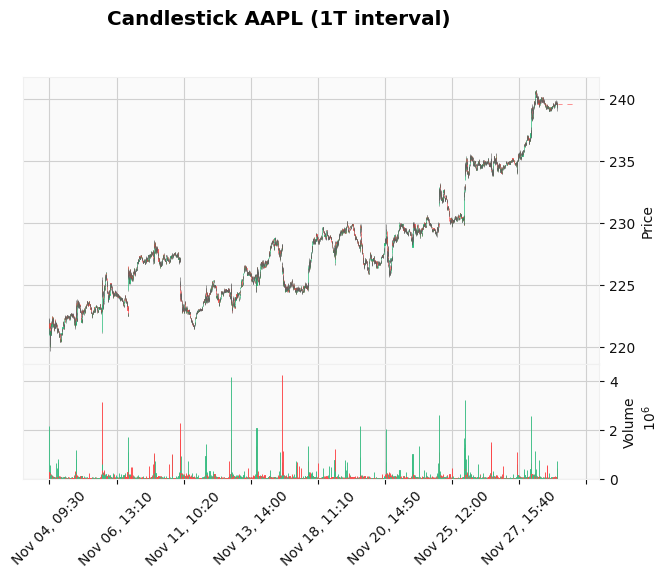

In [85]:
processor.candle_plot(df_clean, tic = 'AAPL')

In [ ]:
# преобразуем дату
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')

In [ ]:
# Отсортируем данные по дате и коду акции
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,2.733996,3.241071,3.251429,3.067143,746015200,AAPL,4
1,2009-01-02,41.484417,58.990002,59.080002,58.590000,6547900,AMGN,4
2,2009-01-02,15.014076,19.330000,19.520000,18.570000,10955700,AXP,4
3,2009-01-02,33.941101,45.250000,45.560001,42.799999,7010200,BA,4
4,2009-01-02,30.602579,46.910000,46.980000,44.910000,7117200,CAT,4


# Часть 4: Предобработка данных
- Импортировать финансовые данные, загруженные из Compustat через WRDS (Wharton Research Data Service).
- Предварительная обработка набора данных и расчет финансовых показателей.
- Добавить эти показатели к данным о ценах, предварительно обработанным в Части 3.
- Рассчитать показатели, связанные с ценами, такие как P/E (цена/прибыль) и P/B (цена/балансовая стоимость).

## 4.1 Импорт финансовых данных

Квартальные финансовые данные для составляющих индекса Dow Jones загружаем с WRDS (Wharton Research Data Services) https://wrds-www.wharton.upenn.edu. Данные, для этого примера содержат информацию с 2009 по 2020 год.

In [ ]:
# Читаем финансовые данные
url = 'https://raw.githubusercontent.com/mariko-sawada/FinRL_with_fundamental_data/main/dow_30_fundamental_wrds.csv'

fund = pd.read_csv(url)
# fund = pd.read_csv('dow_30_fundamental_wrds.csv')

In [ ]:
# Проверим корректность загруженных данных
fund.head()

,gvkey,datadate,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,tic,...,dvpsxq,mkvaltq,prccq,prchq,prclq,adjex,ggroup,gind,gsector,gsubind
0,1447,19990630,1999,2,12,INDL,C,D,STD,AXP,...,0.225,NaN,130.1250,142.6250,114.5000,3.0,4020,402020,40,40202010
1,1447,19990930,1999,3,12,INDL,C,D,STD,AXP,...,0.000,NaN,135.0000,150.6250,121.8750,3.0,4020,402020,40,40202010
2,1447,19991231,1999,4,12,INDL,C,D,STD,AXP,...,0.225,NaN,166.2500,168.8750,130.2500,3.0,4020,402020,40,40202010
3,1447,20000331,2000,1,12,INDL,C,D,STD,AXP,...,0.225,NaN,148.9375,169.5000,119.5000,3.0,4020,402020,40,40202010
4,1447,20000630,2000,2,12,INDL,C,D,STD,AXP,...,0.080,NaN,52.1250,57.1875,43.9375,1.0,4020,402020,40,40202010


## 4.2 Определение элементов, необходимых для расчета финансовых показателей
- Для получения более подробной информации описания данных набора данных, пожалуйста, посетите веб-сайт WRDS (https://wrds-www.wharton.upenn.edu/). Вам потребуется зарегистрироваться.

In [ ]:
# Список элементов, используемых для расчета финансовых показателей

items = [
    'datadate',  # Дата
    'tic',  # Тикер
    'oiadpq',  # Квартальная операционная прибыль
    'revtq',  # Квартальные доходы
    'niq',  # Квартальная чистая прибыль
    'atq',  # Всего активов
    'teqq',  # Собственный капитал
    'epspiy',  # Прибыль на акцию (базовая), включая внештатные элементы
    'ceqq',  # Общий капитал
    'cshoq',  # Общее количество обыкновенных акций
    'dvpspq',  # Дивиденды на акцию
    'actq',  # Оборотные активы
    'lctq',  # Оборотные пассивы
    'cheq',  # Денежные средства и их эквиваленты
    'rectq',  # Дебиторская задолженность
    'cogsq',  # Себестоимость проданных товаров
    'invtq',  # Инвентарь
    'apq',  # Кредиторская задолженность
    'dlttq',  # Долгосрочные обязательства
    'dlcq',  # Задолженность по текущим обязательствам
    'ltq'  # Пассивы
]

# Пропущены элементы, которые не будут использоваться
fund_data = fund[items]

In [ ]:
# Переименование названий столбцов для удобства
fund_data = fund_data.rename(columns={
    'datadate': 'date',  # Дата
    'oiadpq': 'op_inc_q',  # Квартальная операционная прибыль
    'revtq': 'rev_q',  # Квартальные доходы
    'niq': 'net_inc_q',  # Квартальная чистая прибыль
    'atq': 'tot_assets',  # Активы
    'teqq': 'sh_equity',  # Собственный капитал
    'epspiy': 'eps_incl_ex',  # Прибыль на акцию (базовая), включая внештатные элементы
    'ceqq': 'com_eq',  # Общий капитал
    'cshoq': 'sh_outstanding',  # Общее количество обыкновенных акций
    'dvpspq': 'div_per_sh',  # Дивиденды на акцию
    'actq': 'cur_assets',  # Оборотные активы
    'lctq': 'cur_liabilities',  # Оборотные пассивы
    'cheq': 'cash_eq',  # Денежные средства и их эквиваленты
    'rectq': 'receivables',  # Дебиторская задолженность
    'cogsq': 'cogs_q',  # Себестоимость проданных товаров
    'invtq': 'inventories',  # Инвентарь
    'apq': 'payables',  # Кредиторская задолженность
    'dlttq': 'long_debt',  # Долгосрочные обязательства
    'dlcq': 'short_debt',  # Задолженность по текущим обязательствам
    'ltq': 'tot_liabilities'  # Пассивы
})

In [ ]:
# Check the data
fund_data.head()

,date,tic,op_inc_q,rev_q,net_inc_q,tot_assets,sh_equity,eps_incl_ex,com_eq,sh_outstanding,...,cur_assets,cur_liabilities,cash_eq,receivables,cogs_q,inventories,payables,long_debt,short_debt,tot_liabilities
0,19990630,AXP,896.0,5564.0,646.0,132452.0,9762.0,2.73,9762.0,449.0,...,NaN,NaN,6096.0,46774.0,4668.0,448.0,22282.0,7005.0,24785.0,122690.0
1,19990930,AXP,906.0,5584.0,648.0,132616.0,9744.0,4.18,9744.0,447.6,...,NaN,NaN,5102.0,48827.0,4678.0,284.0,23587.0,6720.0,24683.0,122872.0
2,19991231,AXP,845.0,6009.0,606.0,148517.0,10095.0,5.54,10095.0,446.9,...,NaN,NaN,10391.0,54033.0,5164.0,277.0,25719.0,4685.0,32437.0,138422.0
3,20000331,AXP,920.0,6021.0,656.0,150662.0,10253.0,1.48,10253.0,444.7,...,NaN,NaN,7425.0,53663.0,5101.0,315.0,26379.0,5670.0,29342.0,140409.0
4,20000630,AXP,1046.0,6370.0,740.0,148553.0,10509.0,1.05,10509.0,1333.0,...,NaN,NaN,6841.0,54286.0,5324.0,261.0,29536.0,5336.0,26170.0,138044.0


## 4.3 Расчет финансовых показателей
- Для элементов из отчетов о прибылях и убытках мы рассчитываем LTM (Последние двенадцать месяцев) и используем их для выведения показателей, связанных с прибылью, таких как операционная маржа и ROE. Для элементов из балансов мы используем числа на определенный день.
- Для проверки определений расчитываемых здесь финансовых показателей, пожалуйста, обратитесь к веб-сайту CFI: https://corporatefinanceinstitute.com/resources/knowledge/finance/financial-ratios/

Используя имеющиеся показатели, мы рассчитываем 15 финансовых коэффициентов для отражения финансового состояния компаний. Список коэффициентов приведен ниже:
- Коэффициенты прибыльности: Операционная маржа, Чистая маржа, Рентабельность собственного капитала, Рентабельность активов
- Коэффициенты ликвидности: Текущая ликвидность, Коэффициент наличности, Быстрая ликвидность
- Коэффициенты эффективности: Коэффициент оборачиваемости запасов, Коэффициент оборачиваемости кредиторской задолженности, Коэффициент оборачиваемости дебиторской задолженности
- Финансовые коэффициенты кредитного плеча: Коэффициент долга, Коэффициент долга к собственному капиталу
- Коэффициенты оценки рынка: P/E, P/B, Дивидендная доходность

Нам необходимо рассчитать LTM (Последние двенадцать месяцев) для показателей из отчетов о прибылях и убытках, так как мы работаем с квартальными данными. Мы используем значения показателей из балансов, так как они представляют собой числа акций. Например, мы хотим рассчитать ROE к концу третьего квартала в финансовом году 2018 года. В числителе мы суммируем данные о чистой прибыли за четыре квартала.
(Числитель ROE) = Чистая прибыль Q4 2017 года + Q1 2018 года + Q2 2018 года + Q3 2018 года

Мы используем количество собственного капитала в качестве знаменателя на конец Q3 2018 года. То есть,
(Знаменатель ROE) = Собственный капитал на конец Q3 2018 года

Поскольку у нас еще нет данных о ценах на акции в DataFrame, мы рассчитываем только показатели на акцию, такие как прибыль на акцию, для расчета коэффициентов оценки рынка в конце этой части предварительной обработки.

Операционная маржа рассчитывается как отношение операционной прибыли к выручке и выражается в процентах.

Формула для расчета операционной маржи:
$$
\text{Operating Margin} = \frac{\text{Операционная прибыль}}{\text{Выручка}} \times 100\%
$$
Этот показатель позволяет оценить эффективность компании в генерации прибыли от своей основной деятельности. Величина операционной маржи показывает, сколько долларов операционной прибыли компания генерирует на каждый доллар выручки. Более высокие значения операционной маржи обычно указывают на более эффективное управление расходами и более высокую прибыльность бизнеса.


### Чистая прибыль к выручке (Чистая операционная маржа)

Чистая операционная маржа рассчитывается как отношение чистой прибыли к выручке и выражается в процентах.

Формула для расчета чистой операционной маржи:

$$
\text{Net Profit Margin} = \frac{\text{Чистая прибыль}}{\text{Выручка}} \times 100\%
$$

Этот показатель позволяет оценить, какая часть выручки превращается в чистую прибыль после учета всех операционных и неоперационных расходов. Чистая операционная маржа является важным показателем финансовой устойчивости и эффективности бизнеса. Высокие значения этого показателя свидетельствуют о том, что компания эффективно управляет своими расходами и генерирует значительную прибыль от своей деятельности.

### Рентабельность активов (ROA)

Рентабельность активов (ROA) рассчитывается как отношение чистой прибыли к общей сумме активов и выражается в процентах.

Формула для расчета ROA:

$$
\text{Return On Assets (ROA)} = \frac{\text{Чистая прибыль}}{\text{Общая сумма активов}} \times 100\%
$$

ROA показывает, сколько прибыли компания генерирует на каждый доллар активов. Этот показатель помогает инвесторам и аналитикам оценить эффективность использования активов компанией для генерации прибыли. Более высокие значения ROA указывают на более эффективное использование активов и, как следствие, на более высокую прибыльность компании.

### Рентабельность собственного капитала (ROE)

Рентабельность собственного капитала (ROE) рассчитывается как отношение чистой прибыли к собственному капиталу и выражается в процентах.

Формула для расчета ROE:

$$
\text{Return On Equity (ROE)} = \frac{\text{Чистая прибыль}}{\text{Собственный капитал}} \times 100\%
$$

ROE показывает, какую чистую прибыль компания генерирует на каждый доллар собственного капитала. Этот показатель помогает инвесторам и аналитикам оценить эффективность использования собственного капитала компанией для генерации прибыли. Более высокие значения ROE обычно указывают на более эффективное использование собственного капитала и, как следствие, на более высокую прибыльность компании.

### Прибыль на акцию (EPS)

Прибыль на акцию (EPS) рассчитывается как отношение чистой прибыли к общему количеству обыкновенных акций компании.

Формула для расчета EPS:

$$
\text{Earnings Per Share (EPS)} = \frac{\text{Чистая прибыль}}{\text{Общее количество обыкновенных акций}}
$$

EPS показывает, сколько долларов чистой прибыли приходится на одну акцию компании. Этот показатель является важным для инвесторов и аналитиков при оценке прибыльности и стоимости акций компании.

### Собственный капитал на акцию (Book Value Per Share)

Собственный капитал на акцию (Book Value Per Share) рассчитывается как отношение общего собственного капитала компании к общему количеству обыкновенных акций.

Формула для расчета Book Value Per Share:

$$
\text{Book Value Per Share} = \frac{\text{Собственный капитал}}{\text{Общее количество обыкновенных акций}}
$$

Book Value Per Share показывает, сколько долларов собственного капитала приходится на одну акцию компании. Этот показатель используется для оценки стоимости акций и может служить важным индикатором при принятии инвестиционных решений.

### Дивиденды на акцию (Dividends Per Share)

Дивиденды на акцию (Dividends Per Share) рассчитываются как отношение общей суммы выплаченных дивидендов к общему количеству обыкновенных акций.

Формула для расчета Dividends Per Share:

$$
\text{Dividends Per Share} = \frac{\text{Общая сумма выплаченных дивидендов}}{\text{Общее количество обыкновенных акций}}
$$

Dividends Per Share показывает, сколько долларов дивидендов выплачено на одну акцию компании. Этот показатель является важным для инвесторов, которые оценивают потенциальную доходность от дивидендов в связи с инвестициями в акции компании.

### Коэффициенты ликвидности

Коэффициенты ликвидности используются для оценки способности компании погасить свои текущие обязательства за счет доступных у нее активов. Они помогают инвесторам и кредиторам оценить финансовую устойчивость компании и ее способность к платежеспособности.

Наиболее распространенными коэффициентами ликвидности являются:

1. **Коэффициент текущей ликвидности (Current Ratio)**:
$$
\text{Current Ratio} = \frac{\text{Оборотные активы}}{\text{Оборотные пассивы}}
$$
Этот коэффициент показывает, сколько долларов оборотных активов приходится на один доллар оборотных пассивов. Чем выше значение этого коэффициента, тем лучше, так как это указывает на то, что у компании достаточно средств для покрытия своих текущих обязательств.

2. **Быстрый коэффициент ликвидности (Quick Ratio)**:
$$
\text{Quick Ratio} = \frac{\text{Оборотные активы} - \text{Запасы}}{\text{Оборотные пассивы}}
$$
Этот коэффициент исключает запасы из оборотных активов, поскольку запасы могут быть менее ликвидными и могут быть труднее реализовать. Таким образом, Quick Ratio предоставляет оценку ликвидности компании без учета запасов.

3. **Коэффициент абсолютной ликвидности (Absolute Liquidity Ratio)**:
$$
\text{Absolute Liquidity Ratio} = \frac{\text{Денежные средства и эквиваленты}}{\text{Оборотные пассивы}}
$$
Этот коэффициент показывает, какая доля оборотных пассивов компании покрывается ее денежными средствами и эквивалентами. Он оценивает способность компании к немедленному погашению текущих обязательств.

4. **Коэффициент денежной ликвидности (Cash Ratio)**

Коэффициент денежной ликвидности (Cash Ratio) - это мера ликвидности, которая оценивает способность компании погасить текущие обязательства только за счет ее наличных средств и их эквивалентов.

Формула для расчета Cash Ratio:
$$
\text{Cash Ratio} = \frac{\text{Денежные средства и их эквиваленты}}{\text{Оборотные пассивы}}
$$

Этот коэффициент показывает, какая часть оборотных пассивов компании покрывается ее наличными средствами и их эквивалентами. Более высокое значение коэффициента денежной ликвидности указывает на более высокую способность компании погасить свои текущие обязательства без необходимости привлечения дополнительных источников финансирования.

### Коэффициенты эффективности капитала
1. **Коэффициент оборачиваемости запасов (Inventory Turnover Ratio)**

Коэффициент оборачиваемости запасов (Inventory Turnover Ratio) измеряет, сколько раз за определенный период времени компания обновляет свой инвентарь. Этот показатель помогает оценить эффективность управления запасами компании и их оборачиваемость.

Формула для расчета Inventory Turnover Ratio:
$$
\text{Inventory Turnover Ratio} = \frac{\text{Себестоимость проданных товаров}}{\text{Средний объем запасов}}
$$

Где:
- Себестоимость проданных товаров представляет собой затраты, связанные с производством или приобретением товаров, которые были реализованы за рассматриваемый период времени.
- Средний объем запасов можно рассчитать как среднее арифметическое между начальным и конечным объемом запасов за период.

Высокий коэффициент оборачиваемости запасов обычно указывает на то, что компания эффективно управляет своим инвентарем, что может свидетельствовать о более здоровой финансовой позиции. Однако низкий коэффициент оборачиваемости запасов может указывать на проблемы с управлением запасами или на недостаточный спрос на товары компании.

2. **Коэффициент оборачиваемости дебиторской задолженности (Receivables Turnover Ratio)**

Коэффициент оборачиваемости дебиторской задолженности (Receivables Turnover Ratio) измеряет, сколько раз за определенный период времени компания обновляет свою дебиторскую задолженность. Этот показатель помогает оценить эффективность управления кредитными отношениями компании и скорость взыскания долгов.

Формула для расчета Receivables Turnover Ratio:
$$
\text{Receivables Turnover Ratio} = \frac{\text{Выручка}}{\text{Средний объем дебиторской задолженности}}
$$

Где:
- Выручка представляет собой общий объем продаж компании за рассматриваемый период времени.
- Средний объем дебиторской задолженности можно рассчитать как среднее арифметическое между начальным и конечным объемом дебиторской задолженности за период.

Высокий коэффициент оборачиваемости дебиторской задолженности обычно указывает на то, что компания эффективно управляет кредитными отношениями и активно взыскивает долги. Однако низкий коэффициент оборачиваемости дебиторской задолженности может свидетельствовать о проблемах с взысканием долгов или о неэффективном управлении кредитными отношениями.

3. **Коэффициент оборачиваемости кредиторской задолженности (Payable Turnover Ratio)**

Коэффициент оборачиваемости кредиторской задолженности (Payable Turnover Ratio) измеряет, сколько раз за определенный период времени компания обновляет свою кредиторскую задолженность. Этот показатель помогает оценить эффективность управления кредиторскими отношениями компании и ее скорость выплаты долгов.

Формула для расчета Payable Turnover Ratio:
$$
\text{Payable Turnover Ratio} = \frac{\text{Себестоимость проданных товаров}}{\text{Средний объем кредиторской задолженности}}
$$

Где:
- Себестоимость проданных товаров представляет собой затраты, связанные с производством или приобретением товаров, которые были реализованы за рассматриваемый период времени.
- Средний объем кредиторской задолженности можно рассчитать как среднее арифметическое между начальным и конечным объемом кредиторской задолженности за период.

Высокий коэффициент оборачиваемости кредиторской задолженности обычно указывает на то, что компания активно выплачивает свои долги поставщикам. Однако низкий коэффициент оборачиваемости кредиторской задолженности может свидетельствовать о проблемах с платежами или о неэффективном управлении кредиторскими отношениями.

### Финансовые коэффициенты кредитного плеча (Leverage Financial Ratios)

Финансовые коэффициенты кредитного плеча используются для оценки уровня финансового долга компании и ее способности управлять им. Эти показатели позволяют инвесторам и кредиторам оценить финансовую устойчивость компании и ее риск в отношении обязательств.

Наиболее распространенные финансовые коэффициенты кредитного плеча включают:

1. **Коэффициент финансового плеча (Debt-to-Equity Ratio)**:
$$
\text{Debt-to-Equity Ratio} = \frac{\text{Общий долг}}{\text{Собственный капитал}}
$$
Этот коэффициент показывает, сколько долларов долга приходится на один доллар собственного капитала. Он позволяет оценить, в какой степени компания финансируется за счет долга по сравнению с собственным капиталом.

2. **Коэффициент финансовой нагрузки (Financial Leverage Ratio)**:
$$
\text{Financial Leverage Ratio} = \frac{\text{Общий долг}}{\text{Общие активы}}
$$
Этот коэффициент показывает, какая часть активов компании финансируется за счет долга. Он помогает определить степень риска, связанного с использованием долгового финансирования.

3. **Коэффициент краткосрочной ликвидности (Short-term Debt Ratio)**:
$$
\text{Short-term Debt Ratio} = \frac{\text{Краткосрочный долг}}{\text{Общий долг}}
$$
Этот коэффициент показывает, какая доля долга компании является краткосрочным. Он помогает оценить финансовую стабильность компании в краткосрочной перспективе.

4. **Коэффициент капитализации долга (Debt Capitalization Ratio)**:
$$
\text{Debt Capitalization Ratio} = \frac{\text{Общий долг}}{\text{Общий долг} + \text{Собственный капитал}}
$$
Этот коэффициент показывает, какая часть капитализации компании приходится на долг. Он помогает оценить, в какой степени компания зависит от долга для финансирования своей деятельности.

In [ ]:
# Расчет финансовых показателей
date = pd.to_datetime(fund_data['date'],format='%Y%m%d')

tic = fund_data['tic'].to_frame('tic')

# Показатели рентабельности
# Операционная маржа (OPM)
OPM = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='OPM')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        OPM[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        OPM.iloc[i] = np.nan
    else:
        OPM.iloc[i] = np.sum(fund_data['op_inc_q'].iloc[i-3:i])/np.sum(fund_data['rev_q'].iloc[i-3:i])

# Чистая операционная маржа (NPM)
NPM = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='NPM')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        NPM[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        NPM.iloc[i] = np.nan
    else:
        NPM.iloc[i] = np.sum(fund_data['net_inc_q'].iloc[i-3:i])/np.sum(fund_data['rev_q'].iloc[i-3:i])

# Рентабельность активов (ROA)
ROA = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='ROA')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        ROA[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        ROA.iloc[i] = np.nan
    else:
        ROA.iloc[i] = np.sum(fund_data['net_inc_q'].iloc[i-3:i])/fund_data['tot_assets'].iloc[i]

# Рентабельность собственного капитала (ROE)
ROE = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='ROE')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        ROE[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        ROE.iloc[i] = np.nan
    else:
        ROE.iloc[i] = np.sum(fund_data['net_inc_q'].iloc[i-3:i])/fund_data['sh_equity'].iloc[i]

# Для расчета коэффициентов оценки в следующем подразделе предварительно рассчитайте показатели на одну акцию
# Прибыль на акцию (EPS)
EPS = fund_data['eps_incl_ex'].to_frame('EPS')

# Собственный капитал на акцию (Book Value Per Share)
BPS = (fund_data['com_eq']/fund_data['sh_outstanding']).to_frame('BPS') # Need to check units

# Дивиденды на акцию (Dividends Per Share)
DPS = fund_data['div_per_sh'].to_frame('DPS')

# Коэффициенты ликвидности
# Коэффициент текущей ликвидности (Current Ratio)
cur_ratio = (fund_data['cur_assets']/fund_data['cur_liabilities']).to_frame('cur_ratio')

# Быстрый коэффициент ликвидности (Quick Ratio)
quick_ratio = ((fund_data['cash_eq'] + fund_data['receivables'] )/fund_data['cur_liabilities']).to_frame('quick_ratio')

# Коэффициент денежной ликвидности (Cash Ratio)
cash_ratio = (fund_data['cash_eq']/fund_data['cur_liabilities']).to_frame('cash_ratio')


# Коэффициенты эффективности
# Коэффициент оборачиваемости запасов (Inventory Turnover Ratio)
inv_turnover = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='inv_turnover')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        inv_turnover[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        inv_turnover.iloc[i] = np.nan
    else:
        inv_turnover.iloc[i] = np.sum(fund_data['cogs_q'].iloc[i-3:i])/fund_data['inventories'].iloc[i]

# Коэффициент оборачиваемости дебиторской задолженности (Receivables Turnover Ratio)
acc_rec_turnover = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='acc_rec_turnover')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        acc_rec_turnover[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        acc_rec_turnover.iloc[i] = np.nan
    else:
        acc_rec_turnover.iloc[i] = np.sum(fund_data['rev_q'].iloc[i-3:i])/fund_data['receivables'].iloc[i]

# Коэффициент оборачиваемости кредиторской задолженности (Payable Turnover Ratio)
acc_pay_turnover = pd.Series(np.empty(fund_data.shape[0],dtype=object),name='acc_pay_turnover')
for i in range(0, fund_data.shape[0]):
    if i-3 < 0:
        acc_pay_turnover[i] = np.nan
    elif fund_data.iloc[i,1] != fund_data.iloc[i-3,1]:
        acc_pay_turnover.iloc[i] = np.nan
    else:
        acc_pay_turnover.iloc[i] = np.sum(fund_data['cogs_q'].iloc[i-3:i])/fund_data['payables'].iloc[i]

## Коэффициенты кредитного плеча (Leverage Financial Ratios)
# Коэффициент капитализации долга (Debt Capitalization Ratio)
debt_ratio = (fund_data['tot_liabilities']/fund_data['tot_assets']).to_frame('debt_ratio')

# Коэффициент финансового плеча (Debt-to-Equity Ratio)
debt_to_equity = (fund_data['tot_liabilities']/fund_data['sh_equity']).to_frame('debt_to_equity')

In [ ]:
# Соберем датафрейм со всеми рассчитанными показателями
ratios = pd.concat([date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,
                    cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,
                   debt_ratio,debt_to_equity], axis=1)

In [ ]:
# Check the ratio data
ratios.head()

,date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
0,1999-06-30,AXP,NaN,NaN,NaN,NaN,2.73,21.741648,0.225,NaN,NaN,NaN,NaN,NaN,NaN,0.926298,12.568121
1,1999-09-30,AXP,NaN,NaN,NaN,NaN,4.18,21.769437,0.225,NaN,NaN,NaN,NaN,NaN,NaN,0.926525,12.610016
2,1999-12-31,AXP,NaN,NaN,NaN,NaN,5.54,22.588946,0.225,NaN,NaN,NaN,NaN,NaN,NaN,0.932028,13.711937
3,2000-03-31,AXP,0.154281,0.110742,0.012611,0.185312,1.48,23.055993,0.225,NaN,NaN,NaN,46.063492,0.319717,0.550059,0.931947,13.694431
4,2000-06-30,AXP,0.151641,0.108436,0.012857,0.181749,1.05,7.883721,0.080,NaN,NaN,NaN,57.252874,0.324467,0.505925,0.929258,13.135788


In [ ]:
ratios.tail()

,date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
2451,2020-03-31,V,0.667517,0.521213,0.129058,0.271736,2.85,13.647142,0.30,1.248714,1.140070,0.955150,inf,6.11635,2.697537,0.525062,1.105537
2452,2020-06-30,V,0.668385,0.519867,0.120448,0.264075,3.92,14.203947,0.30,1.553478,1.443292,1.221925,inf,5.063131,1.889507,0.543886,1.192433
2453,2020-09-30,V,0.654464,0.52129,0.107873,0.241066,4.90,14.653484,0.30,1.905238,1.784838,1.579807,inf,5.628571,2.730366,0.552515,1.234714
2454,2020-12-31,V,0.638994,0.480876,0.094422,0.201545,1.42,15.908283,0.32,2.121065,1.969814,1.700081,inf,4.725314,2.347866,0.531507,1.134505
2455,2021-03-31,V,0.640128,0.488704,0.095218,0.202568,2.80,16.088525,0.32,2.116356,1.954292,1.700574,inf,4.844961,2.367357,0.529946,1.127414


## 4.4 Обработка пропусков
Заменим пропуски и NA на ноль.

In [ ]:
# Replace NAs infinite values with zero
final_ratios = ratios.copy()
final_ratios = final_ratios.fillna(0)
final_ratios = final_ratios.replace(np.inf,0)

In [ ]:
final_ratios.head()

,date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
0,1999-06-30,AXP,0.000000,0.000000,0.000000,0.000000,2.73,21.741648,0.225,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.926298,12.568121
1,1999-09-30,AXP,0.000000,0.000000,0.000000,0.000000,4.18,21.769437,0.225,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.926525,12.610016
2,1999-12-31,AXP,0.000000,0.000000,0.000000,0.000000,5.54,22.588946,0.225,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.932028,13.711937
3,2000-03-31,AXP,0.154281,0.110742,0.012611,0.185312,1.48,23.055993,0.225,0.0,0.0,0.0,46.063492,0.319717,0.550059,0.931947,13.694431
4,2000-06-30,AXP,0.151641,0.108436,0.012857,0.181749,1.05,7.883721,0.080,0.0,0.0,0.0,57.252874,0.324467,0.505925,0.929258,13.135788


In [ ]:
final_ratios.tail()

,date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
2451,2020-03-31,V,0.667517,0.521213,0.129058,0.271736,2.85,13.647142,0.30,1.248714,1.140070,0.955150,0.0,6.116350,2.697537,0.525062,1.105537
2452,2020-06-30,V,0.668385,0.519867,0.120448,0.264075,3.92,14.203947,0.30,1.553478,1.443292,1.221925,0.0,5.063131,1.889507,0.543886,1.192433
2453,2020-09-30,V,0.654464,0.521290,0.107873,0.241066,4.90,14.653484,0.30,1.905238,1.784838,1.579807,0.0,5.628571,2.730366,0.552515,1.234714
2454,2020-12-31,V,0.638994,0.480876,0.094422,0.201545,1.42,15.908283,0.32,2.121065,1.969814,1.700081,0.0,4.725314,2.347866,0.531507,1.134505
2455,2021-03-31,V,0.640128,0.488704,0.095218,0.202568,2.80,16.088525,0.32,2.116356,1.954292,1.700574,0.0,4.844961,2.367357,0.529946,1.127414


## 4.5 Соберем все вместе с ценами в итоговый датасет для моделирования
- Объединим DataFrame с ценами, предварительно обработанный в части 3, и DataFrame с коэффициентами, созданный в этой части.
- Поскольку цены представлены ежедневно, а коэффициенты - квартально, после объединения двух DataFrame в столбцах с коэффициентами будут пропущенные значения. Мы решаем эту проблему, заполняя пропущенные значения последним известным значением коэффициента.

In [ ]:
list_ticker = df["tic"].unique().tolist()
list_date = list(pd.date_range(df['date'].min(),df['date'].max()))
combination = list(itertools.product(list_date,list_ticker))

# Merge stock price data and ratios into one dataframe
processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(df,on=["date","tic"],how="left")
processed_full = processed_full.merge(final_ratios,how='left',on=['date','tic'])
processed_full = processed_full.sort_values(['tic','date'])

# Backfill the ratio data to make them daily
processed_full = processed_full.bfill(axis='rows')


## 4.6 Рассчитать рыночные оценочные коэффициенты, используя ежедневные данные о ценах на акции.

In [ ]:
# Рассчитайте коэффициенты P/E (цена/прибыль), P/B (цена/балансовая стоимость) и дивидендную доходность с использованием ежедневной цены закрытия.
processed_full['PE'] = processed_full['close']/processed_full['EPS']
processed_full['PB'] = processed_full['close']/processed_full['BPS']
processed_full['Div_yield'] = processed_full['DPS']/processed_full['close']

# Удалим показатели на одну акцию, использованные для расчета коэффициентов.
processed_full = processed_full.drop(columns=['day','EPS','BPS','DPS'])

# Заменить пропуски нулями
processed_full = processed_full.copy()
processed_full = processed_full.fillna(0)
processed_full = processed_full.replace(np.inf,0)

In [ ]:
# посмотрим на финальный датасет для моделирования
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,OPM,NPM,ROA,...,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2009-01-02,AAPL,2.733996,3.241071,3.251429,3.067143,746015200.0,0.217886,0.163846,0.103222,...,2.039779,1.818995,54.403846,8.972003,4.269115,0.437727,0.778495,0.705090,0.112526,0.000000
1,2009-01-02,AMGN,41.484417,58.990002,59.080002,58.590000,6547900.0,0.093973,0.072040,0.014094,...,0.000000,0.000000,0.000000,0.351354,0.653355,0.869784,6.679531,189.000000,5.426032,0.003072
2,2009-01-02,AXP,15.014076,19.330000,19.520000,18.570000,10955700.0,0.093973,0.072040,0.014094,...,0.000000,0.000000,0.000000,0.351354,0.653355,0.869784,6.679531,59.903225,1.719772,0.009693
3,2009-01-02,BA,33.941101,45.250000,45.560001,42.799999,7010200.0,0.047307,0.032525,0.026400,...,0.368463,0.148507,2.329670,6.815203,2.076967,1.009198,-109.722986,49.195401,-45.082364,0.009813
4,2009-01-02,CAT,30.602579,46.910000,46.980000,44.910000,7117200.0,0.124545,0.066662,0.040891,...,0.890488,0.163158,3.540791,2.460351,8.472455,0.893715,9.089489,-236.368420,4.334744,0.009352
5,2009-01-02,CRM,8.467410,8.505000,8.550000,8.025000,4069200.0,0.234698,0.196418,0.097593,...,2.498162,2.170759,9.054201,6.844634,16.036800,0.400215,0.667591,12.738095,1.274994,0.000000
6,2009-01-02,CSCO,11.317224,16.959999,17.000000,16.410000,40980600.0,0.234698,0.196418,0.097593,...,2.498162,2.170759,9.054201,6.844634,16.036800,0.400215,0.667591,26.047619,2.607184,0.000000
7,2009-01-02,CVX,40.646381,76.519997,77.300003,74.230003,13695900.0,0.141417,0.097223,0.117691,...,0.952878,0.373760,23.920348,13.387209,11.276861,0.449174,0.815455,80.684786,1.704292,0.008757
8,2009-01-02,DIS,20.436300,23.920000,24.030001,22.760000,9796600.0,0.167221,0.102157,0.045834,...,0.815629,0.330748,11.310223,5.725855,4.287167,0.455848,0.837721,28.810127,1.244782,0.015378
9,2009-01-02,DOW,37.268898,49.799999,53.500000,52.750000,2350800.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.347826,0.000000,0.000000


<a id='4'></a>
# Часть 5. Модель рынка
Процесс обучения включает наблюдение за изменением цен на акции, принятие решения и расчет вознаграждения. Взаимодействуя с рыночной средой, агент в конечном итоге разработает торговую стратегию, которая поможет ему максимизировать (ожидаемые) вознаграждения.

Модель рыночной среды, основанная на OpenAI Gym, моделирует фондовые рынки на исторических рыночных данных.

## 5.1 Разделим данные на train и test (trade)
- Training data period: 2009-01-01 to 2019-01-01
- Trade data period: 2019-01-01 to 2020-12-31

In [ ]:
train_data = data_split(processed_full, TRAIN_START_DATE, TRAIN_END_DATE)
trade_data = data_split(processed_full, TEST_START_DATE, TEST_END_DATE)
# Check the length of the two datasets
print(len(train_data))
print(len(trade_data))

109530
21930


In [ ]:
train_data.head()

,date,tic,open,high,low,close,volume,OPM,NPM,ROA,...,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2009-01-02,AAPL,2.733996,3.241071,3.251429,3.067143,746015200.0,0.217886,0.163846,0.103222,...,2.039779,1.818995,54.403846,8.972003,4.269115,0.437727,0.778495,0.705090,0.112526,0.000000
0,2009-01-02,AMGN,41.484417,58.990002,59.080002,58.590000,6547900.0,0.093973,0.072040,0.014094,...,0.000000,0.000000,0.000000,0.351354,0.653355,0.869784,6.679531,189.000000,5.426032,0.003072
0,2009-01-02,AXP,15.014076,19.330000,19.520000,18.570000,10955700.0,0.093973,0.072040,0.014094,...,0.000000,0.000000,0.000000,0.351354,0.653355,0.869784,6.679531,59.903225,1.719772,0.009693
0,2009-01-02,BA,33.941101,45.250000,45.560001,42.799999,7010200.0,0.047307,0.032525,0.026400,...,0.368463,0.148507,2.329670,6.815203,2.076967,1.009198,-109.722986,49.195401,-45.082364,0.009813
0,2009-01-02,CAT,30.602579,46.910000,46.980000,44.910000,7117200.0,0.124545,0.066662,0.040891,...,0.890488,0.163158,3.540791,2.460351,8.472455,0.893715,9.089489,-236.368420,4.334744,0.009352


In [ ]:
trade_data.head()

,date,tic,open,high,low,close,volume,OPM,NPM,ROA,...,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2019-01-01,AAPL,37.708591,39.480000,39.712502,38.722500,148158800.0,0.258891,0.227773,0.133360,...,1.134347,0.854114,23.571867,7.620024,3.781658,0.690466,2.230663,5.779478,1.685297,0.018852
0,2019-01-01,AMGN,159.867645,191.899994,193.199997,192.520004,3009100.0,0.093973,0.072040,0.014094,...,0.000000,0.000000,0.000000,0.351354,0.653355,0.869784,6.679531,621.032272,17.829319,0.000935
0,2019-01-01,AXP,88.031578,95.680000,96.269997,93.910004,4175400.0,0.203479,0.160494,0.026811,...,0.000000,0.000000,0.000000,0.231669,0.279424,0.887329,7.875371,51.883980,3.537792,0.004153
0,2019-01-01,BA,314.645172,323.809998,323.950012,316.190002,3292200.0,0.116496,0.102682,0.066409,...,0.262465,0.092436,0.933164,5.468453,4.151637,0.998070,517.142241,83.427441,1425.159404,0.006499
0,2019-01-01,CAT,110.120682,126.379997,127.879997,124.029999,4783200.0,0.186871,0.107064,0.056932,...,0.919490,0.266175,2.135008,2.339630,3.660183,0.803394,4.086316,37.699088,4.593392,0.006934


## 5.2 Построим модель рынка

In [ ]:
import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gym import spaces
from gym.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv

# matplotlib.use("Agg")

# from stable_baselines3.common import logger


class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df,
        stock_dim,
        hmax,
        initial_amount,
        buy_cost_pct,
        sell_cost_pct,
        reward_scaling,
        state_space,
        action_space,
        tech_indicator_list,
        turbulence_threshold=None,
        risk_indicator_col="turbulence",
        make_plots=False,
        print_verbosity=10,
        day=0,
        initial=True,
        previous_state=[],
        model_name="",
        mode="",
        iteration="",
    ):
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.action_space,))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        self.data = self.df.loc[self.day, :]
        self.terminal = False
        self.make_plots = make_plots
        self.print_verbosity = print_verbosity
        self.turbulence_threshold = turbulence_threshold
        self.risk_indicator_col = risk_indicator_col
        self.initial = initial
        self.previous_state = previous_state
        self.model_name = model_name
        self.mode = mode
        self.iteration = iteration
        # initalize state
        self.state = self._initiate_state()

        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode = 0
        # memorize all the total balance change
        self.asset_memory = [self.initial_amount]
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]
        # self.reset()
        self._seed()

    def _sell_stock(self, index, action):
        def _do_sell_normal():
            if self.state[index + 1] > 0:
                # Sell only if the price is > 0 (no missing data in this particular date)
                # perform sell action based on the sign of the action
                if self.state[index + self.stock_dim + 1] > 0:
                    # Sell only if current asset is > 0
                    sell_num_shares = min(
                        abs(action), self.state[index + self.stock_dim + 1]
                    )
                    sell_amount = (
                        self.state[index + 1]
                        * sell_num_shares
                        * (1 - self.sell_cost_pct)
                    )
                    # update balance
                    self.state[0] += sell_amount

                    self.state[index + self.stock_dim + 1] -= sell_num_shares
                    self.cost += (
                        self.state[index + 1] * sell_num_shares * self.sell_cost_pct
                    )
                    self.trades += 1
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = 0

            return sell_num_shares

        # perform sell action based on the sign of the action
        if self.turbulence_threshold is not None:
            if self.turbulence >= self.turbulence_threshold:
                if self.state[index + 1] > 0:
                    # Sell only if the price is > 0 (no missing data in this particular date)
                    # if turbulence goes over threshold, just clear out all positions
                    if self.state[index + self.stock_dim + 1] > 0:
                        # Sell only if current asset is > 0
                        sell_num_shares = self.state[index + self.stock_dim + 1]
                        sell_amount = (
                            self.state[index + 1]
                            * sell_num_shares
                            * (1 - self.sell_cost_pct)
                        )
                        # update balance
                        self.state[0] += sell_amount
                        self.state[index + self.stock_dim + 1] = 0
                        self.cost += (
                            self.state[index + 1] * sell_num_shares * self.sell_cost_pct
                        )
                        self.trades += 1
                    else:
                        sell_num_shares = 0
                else:
                    sell_num_shares = 0
            else:
                sell_num_shares = _do_sell_normal()
        else:
            sell_num_shares = _do_sell_normal()

        return sell_num_shares

    def _buy_stock(self, index, action):
        def _do_buy():
            if self.state[index + 1] > 0:
                # Buy only if the price is > 0 (no missing data in this particular date)
                available_amount = self.state[0] // self.state[index + 1]
                # print('available_amount:{}'.format(available_amount))

                # update balance
                buy_num_shares = min(available_amount, action)
                buy_amount = (
                    self.state[index + 1] * buy_num_shares * (1 + self.buy_cost_pct)
                )
                self.state[0] -= buy_amount

                self.state[index + self.stock_dim + 1] += buy_num_shares

                self.cost += self.state[index + 1] * buy_num_shares * self.buy_cost_pct
                self.trades += 1
            else:
                buy_num_shares = 0

            return buy_num_shares

        # perform buy action based on the sign of the action
        if self.turbulence_threshold is None:
            buy_num_shares = _do_buy()
        else:
            if self.turbulence < self.turbulence_threshold:
                buy_num_shares = _do_buy()
            else:
                buy_num_shares = 0
                pass

        return buy_num_shares

    def _make_plot(self):
        plt.plot(self.asset_memory, "r")
        plt.savefig("results/account_value_trade_{}.png".format(self.episode))
        plt.close()

    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique()) - 1
        if self.terminal:
            # print(f"Episode: {self.episode}")
            if self.make_plots:
                self._make_plot()
            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            df_total_value = pd.DataFrame(self.asset_memory)
            tot_reward = (
                self.state[0]
                + sum(
                    np.array(self.state[1 : (self.stock_dim + 1)])
                    * np.array(
                        self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                    )
                )
                - self.initial_amount
            )
            df_total_value.columns = ["account_value"]
            df_total_value["date"] = self.date_memory
            df_total_value["daily_return"] = df_total_value["account_value"].pct_change(
                1
            )
            if df_total_value["daily_return"].std() != 0:
                sharpe = (
                    (252 ** 0.5)
                    * df_total_value["daily_return"].mean()
                    / df_total_value["daily_return"].std()
                )
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.columns = ["account_rewards"]
            df_rewards["date"] = self.date_memory[:-1]
            if self.episode % self.print_verbosity == 0:
                print(f"day: {self.day}, episode: {self.episode}")
                print(f"begin_total_asset: {self.asset_memory[0]:0.2f}")
                print(f"end_total_asset: {end_total_asset:0.2f}")
                print(f"total_reward: {tot_reward:0.2f}")
                print(f"total_cost: {self.cost:0.2f}")
                print(f"total_trades: {self.trades}")
                if df_total_value["daily_return"].std() != 0:
                    print(f"Sharpe: {sharpe:0.3f}")
                print("=================================")

            if (self.model_name != "") and (self.mode != ""):
                df_actions = self.save_action_memory()
                df_actions.to_csv(
                    "results/actions_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    )
                )
                df_total_value.to_csv(
                    "results/account_value_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                df_rewards.to_csv(
                    "results/account_rewards_{}_{}_{}.csv".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.plot(self.asset_memory, "r")
                plt.savefig(
                    "results/account_value_{}_{}_{}.png".format(
                        self.mode, self.model_name, self.iteration
                    ),
                    index=False,
                )
                plt.close()

            # Add outputs to logger interface
            # logger.record("environment/portfolio_value", end_total_asset)
            # logger.record("environment/total_reward", tot_reward)
            # logger.record("environment/total_reward_pct", (tot_reward / (end_total_asset - tot_reward)) * 100)
            # logger.record("environment/total_cost", self.cost)
            # logger.record("environment/total_trades", self.trades)

            return self.state, self.reward, self.terminal, {}

        else:

            actions = actions * self.hmax  # actions initially is scaled between 0 to 1
            actions = actions.astype(
                int
            )  # convert into integer because we can't by fraction of shares
            if self.turbulence_threshold is not None:
                if self.turbulence >= self.turbulence_threshold:
                    actions = np.array([-self.hmax] * self.stock_dim)
            begin_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            # print("begin_total_asset:{}".format(begin_total_asset))

            argsort_actions = np.argsort(actions)

            sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][: np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print(f"Num shares before: {self.state[index+self.stock_dim+1]}")
                # print(f'take sell action before : {actions[index]}')
                actions[index] = self._sell_stock(index, actions[index]) * (-1)
                # print(f'take sell action after : {actions[index]}')
                # print(f"Num shares after: {self.state[index+self.stock_dim+1]}")

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                actions[index] = self._buy_stock(index, actions[index])

            self.actions_memory.append(actions)

            # state: s -> s+1
            self.day += 1
            self.data = self.df.loc[self.day, :]
            if self.turbulence_threshold is not None:
                if len(self.df.tic.unique()) == 1:
                    self.turbulence = self.data[self.risk_indicator_col]
                elif len(self.df.tic.unique()) > 1:
                    self.turbulence = self.data[self.risk_indicator_col].values[0]
            self.state = self._update_state()

            end_total_asset = self.state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
            )
            self.asset_memory.append(end_total_asset)
            self.date_memory.append(self._get_date())
            self.reward = end_total_asset - begin_total_asset
            self.rewards_memory.append(self.reward)
            self.reward = self.reward * self.reward_scaling

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        # initiate state
        self.state = self._initiate_state()

        if self.initial:
            self.asset_memory = [self.initial_amount]
        else:
            previous_total_asset = self.previous_state[0] + sum(
                np.array(self.state[1 : (self.stock_dim + 1)])
                * np.array(
                    self.previous_state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)]
                )
            )
            self.asset_memory = [previous_total_asset]

        self.day = 0
        self.data = self.df.loc[self.day, :]
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.terminal = False
        # self.iteration=self.iteration
        self.rewards_memory = []
        self.actions_memory = []
        self.date_memory = [self._get_date()]

        self.episode += 1

        return self.state

    def render(self, mode="human", close=False):
        return self.state

    def _initiate_state(self):
        if self.initial:
            # For Initial State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.initial_amount]
                    + self.data.close.values.tolist()
                    + [0] * self.stock_dim
                    + sum(
                        [
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ],
                        [],
                    )
                )
            else:
                # for single stock
                state = (
                    [self.initial_amount]
                    + [self.data.close]
                    + [0] * self.stock_dim
                    + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
                )
        else:
            # Using Previous State
            if len(self.df.tic.unique()) > 1:
                # for multiple stock
                state = (
                    [self.previous_state[0]]
                    + self.data.close.values.tolist()
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum(
                        [
                            self.data[tech].values.tolist()
                            for tech in self.tech_indicator_list
                        ],
                        [],
                    )
                )
            else:
                # for single stock
                state = (
                    [self.previous_state[0]]
                    + [self.data.close]
                    + self.previous_state[
                        (self.stock_dim + 1) : (self.stock_dim * 2 + 1)
                    ]
                    + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
                )
        return state

    def _update_state(self):
        if len(self.df.tic.unique()) > 1:
            # for multiple stock
            state = (
                [self.state[0]]
                + self.data.close.values.tolist()
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum(
                    [
                        self.data[tech].values.tolist()
                        for tech in self.tech_indicator_list
                    ],
                    [],
                )
            )

        else:
            # for single stock
            state = (
                [self.state[0]]
                + [self.data.close]
                + list(self.state[(self.stock_dim + 1) : (self.stock_dim * 2 + 1)])
                + sum([[self.data[tech]] for tech in self.tech_indicator_list], [])
            )
        return state

    def _get_date(self):
        if len(self.df.tic.unique()) > 1:
            date = self.data.date.unique()[0]
        else:
            date = self.data.date
        return date

    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        # print(len(date_list))
        # print(len(asset_list))
        df_account_value = pd.DataFrame(
            {"date": date_list, "account_value": asset_list}
        )
        return df_account_value

    def save_action_memory(self):
        if len(self.df.tic.unique()) > 1:
            # date and close price length must match actions length
            date_list = self.date_memory[:-1]
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = self.actions_memory
            df_actions = pd.DataFrame(action_list)
            df_actions.columns = self.data.tic.values
            df_actions.index = df_date.date
            # df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        else:
            date_list = self.date_memory[:-1]
            action_list = self.actions_memory
            df_actions = pd.DataFrame({"date": date_list, "actions": action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [ ]:
ratio_list = ['OPM', 'NPM','ROA', 'ROE', 'cur_ratio', 'quick_ratio', 'cash_ratio', 'inv_turnover','acc_rec_turnover', 'acc_pay_turnover', 'debt_ratio', 'debt_to_equity',
       'PE', 'PB', 'Div_yield']

stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(ratio_list)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 30, State Space: 511


In [ ]:
# Параметры среды (модели рынка)
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": ratio_list,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4

}

#Establish the training environment using StockTradingEnv() class
e_train_gym = StockTradingEnv(df = train_data, **env_kwargs)

## Создаем экземпляр окружения для тренировки модели

In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [ ]:
!pip install shimmy

<a id='5'></a>
# Часть 6: Тренировка агента
* Алгоритмы DRL взяты из **Stable Baselines 3**. Так же можно использовать `ElegantRL` и `Ray RLlib`.
* Библиотека FinRL включает настроенные стандартные алгоритмы DRL, такие как DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C и TD3. Мы также позволяем пользователям создавать свои собственные алгоритмы DRL, адаптируя эти алгоритмы DRL.

In [ ]:
# Set up the agent using DRLAgent() class using the environment created in the previous part
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

### Обучим агента: 5 алгоритмов (A2C, DDPG, PPO, TD3, SAC)

### Model 1: PPO

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [ ]:
if exists('./trained_models/trained_ppo.model'):
    trained_ppo = model_ppo.load('./trained_models/trained_ppo.model')
else:
    trained_ppo = agent.train_model(model=model_ppo,
                            tb_log_name='ppo',
                            total_timesteps=50000) if if_using_ppo else None

    trained_ppo.save('./trained_models/trained_ppo.model')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-----------------------------------
| time/              |            |
|    fps             | 65         |
|    iterations      | 1          |
|    time_elapsed    | 31         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | -0.6352093 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 63          |
|    iterations           | 2           |
|    time_elapsed         | 64          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015215192 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.6       |
|    explained_variance   | -0.0383     |
|    learning_rate        | 0.00025     |
|    loss                 | 1.84        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0178     |
|   

### Model 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg


In [ ]:
if exists('./trained_models/trained_ddpg.model'):
    trained_ddpg = model_ddpg.load('./trained_models/trained_ddpg.model')
else:
    trained_ddpg = agent.train_model(model=model_ddpg,
                            tb_log_name='ddpg',
                            total_timesteps=50000) if if_using_ddpg else None

    trained_ddpg.save('./trained_models/trained_ddpg.model')

day: 3650, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 3021130.21
total_reward: 2021130.21
total_cost: 998.99
total_trades: 40150
Sharpe: 0.728
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 17       |
|    time_elapsed    | 832      |
|    total_timesteps | 14604    |
| train/             |          |
|    actor_loss      | 39.2     |
|    critic_loss     | 549      |
|    learning_rate   | 0.001    |
|    n_updates       | 14503    |
|    reward          | 0.0      |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 17       |
|    time_elapsed    | 1698     |
|    total_timesteps | 29208    |
| train/             |          |
|    actor_loss      | 22.6     |
|    critic_loss     | 2.1      |
|    learning_rate   | 0.001    |
|    n_updates       | 29107    |
|    reward          | 0.

### Model 3: A2C


In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [ ]:
if exists('./trained_models/trained_a2c.model'):
    trained_a2c = model_a2c.load('./trained_models/trained_a2c.model')
else:
    trained_a2c = agent.train_model(model=model_a2c,
                                tb_log_name='a2c',
                                total_timesteps=50000) if if_using_a2c else None

    trained_a2c.save('./trained_models/trained_a2c.model')

-----------------------------------------
| time/                 |               |
|    fps                | 56            |
|    iterations         | 100           |
|    time_elapsed       | 8             |
|    total_timesteps    | 500           |
| train/                |               |
|    entropy_loss       | -42.7         |
|    explained_variance | -1.19e-07     |
|    learning_rate      | 0.0007        |
|    n_updates          | 99            |
|    policy_loss        | 99.2          |
|    reward             | -0.0009740665 |
|    std                | 1.01          |
|    value_loss         | 7.32          |
-----------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 61          |
|    iterations         | 200         |
|    time_elapsed       | 16          |
|    total_timesteps    | 1000        |
| train/                |             |
|    entropy_loss       | -42.7       |
|    exp

### Model 4: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100,
              "buffer_size": 1000000,
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to results/td3


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
if exists('./trained_models/trained_td3.model'):
    trained_td3 = model_td3.load('./trained_models/trained_td3.model')
else:
    trained_td3 = agent.train_model(model=model_td3,
                                tb_log_name='td3',
                                total_timesteps=30000) if if_using_td3 else None

    trained_td3.save('./trained_models/trained_td3.model')

---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 18       |
|    time_elapsed    | 773      |
|    total_timesteps | 14604    |
| train/             |          |
|    actor_loss      | 8.38     |
|    critic_loss     | 32       |
|    learning_rate   | 0.001    |
|    n_updates       | 14503    |
|    reward          | 0.0      |
---------------------------------
day: 3650, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 2503299.89
total_reward: 1503299.89
total_cost: 999.00
total_trades: 83939
Sharpe: 0.552
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 18       |
|    time_elapsed    | 1591     |
|    total_timesteps | 29208    |
| train/             |          |
|    actor_loss      | 9.26     |
|    critic_loss     | 4.45     |
|    learning_rate   | 0.001    |
|    n_updates       | 29107    |
|    reward          | 0.

### Model 5: SAC

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac", model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac


In [ ]:
if exists('./trained_models/trained_sac.model'):
    trained_sac = model_sac.load('./trained_models/trained_sac.model')
else:
    trained_sac = agent.train_model(model=model_sac,
                                tb_log_name='sac',
                                total_timesteps=30000) if if_using_sac else None

    trained_sac.save('./trained_models/trained_sac.model')

-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 19         |
|    time_elapsed    | 763        |
|    total_timesteps | 14604      |
| train/             |            |
|    actor_loss      | 188        |
|    critic_loss     | 28.4       |
|    ent_coef        | 0.0697     |
|    ent_coef_loss   | -117       |
|    learning_rate   | 0.0001     |
|    n_updates       | 14503      |
|    reward          | -9.068e-06 |
-----------------------------------
day: 3650, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 3416832.92
total_reward: 2416832.92
total_cost: 17221.50
total_trades: 67113
Sharpe: 0.594
---------------------------------------
| time/              |                |
|    episodes        | 8              |
|    fps             | 18             |
|    time_elapsed    | 1542           |
|    total_timesteps | 29208          |
| train/             |                |
|    actor_loss    

## Торговля
В начальный момент времени (`TEST_START_DATE`) мы будем располагать начальным капиталом в 1,000,000$. Попробуем торговать с использование наших моделей на акциях списка Dow jones 30.

### Торговля

Модели DRL нужно периодически обновлять, чтобы использовать последние данные. В идеале, мы должны переобучать нашу модель ежегодно, ежеквартально или ежемесячно по мере убывания ее качества предсказания. Также нам нужно настраивать параметры.
В этом примере мы используем только данные с 2009-01 по 2018-12 для настройки параметров модели один раз, поэтому здесь есть некоторое убывание качества модели со сременем.

Множество гиперпараметров, таких как скорость обучения, общее количество образцов для обучения так же влияют на процесс обучения и обычно определяются путем тестирования различных вариантов. Пробуйте эти варианты самостоятельно для повышения качества моделей.

In [ ]:
trade_data = data_split(processed_full, TEST_START_DATE, TEST_END_DATE)
e_trade_gym = StockTradingEnv(df = trade_data, **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [ ]:
trade_data.head()

,date,tic,open,high,low,close,volume,OPM,NPM,ROA,...,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2019-01-01,AAPL,38.722500,39.712502,38.557499,37.750084,148158800.0,0.258891,0.227773,0.133360,...,1.134347,0.854114,23.571867,7.620024,3.781658,0.690466,2.230663,5.634341,1.642975,0.019338
0,2019-01-01,AMGN,192.520004,193.199997,188.949997,161.146057,3009100.0,0.093973,0.072040,0.014094,...,0.000000,0.000000,0.000000,0.351354,0.653355,0.869784,6.679531,519.825991,14.923771,0.001117
0,2019-01-01,AXP,93.910004,96.269997,93.769997,88.031563,4175400.0,0.203479,0.160494,0.026811,...,0.000000,0.000000,0.000000,0.231669,0.279424,0.887329,7.875371,48.636223,3.316339,0.004430
0,2019-01-01,BA,316.190002,323.950012,313.709991,314.645142,3292200.0,0.116496,0.102682,0.066409,...,0.262465,0.092436,0.933164,5.468453,4.151637,0.998070,517.142241,83.019826,1418.196271,0.006531
0,2019-01-01,CAT,124.029999,127.879997,123.000000,110.516350,4783200.0,0.186871,0.107064,0.056932,...,0.919490,0.266175,2.135008,2.339630,3.660183,0.803394,4.086316,33.591596,4.092921,0.007782


In [ ]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment = e_trade_gym) if if_using_ppo else [None, None]

df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg,
    environment = e_trade_gym) if if_using_ddpg else [None, None]

df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment = e_trade_gym) if if_using_a2c else [None, None]

df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3,
    environment = e_trade_gym) if if_using_td3 else [None, None]

df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac,
    environment = e_trade_gym) if if_using_sac else [None, None]

hit end!
hit end!
hit end!
hit end!
hit end!


<a id='6'></a>
# Часть 7: Проведение обратного тестирования торговой стратегии

Обратное тестирование играет ключевую роль в оценке производительности торговой стратегии. Автоматизированный инструмент обратного тестирования предпочтительнее, поскольку он снижает вероятность человеческой ошибки.

В `FinRL` обычно используется пакет `pyfolio` из `Quantopian` для обратного тестирования торговых стратегий. Он легок в использовании и состоит из различных отдельных графиков, которые предоставляют комплексное представление о производительности торговой стратегии.

<div class="alert alert-warning"><b>Ошибка обновления пакетов!</b>

В данный момент пакет pyfolio отстает в обновлении от библиотек numpy и sklearn и при его использовании возникает ряд ошибок, связанных с несоотвествием типов данных.

<b>Используйте его с осторожностью.</b></div>

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

if if_using_ppo:
  print("\n ppo:")
  perf_stats_all_ppo = backtest_stats(account_value=df_account_value_ppo)
  perf_stats_all_ppo = pd.DataFrame(perf_stats_all_ppo)
  perf_stats_all_ppo.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ppo_"+now+'.csv')

if if_using_ddpg:
  print("\n ddpg:")
  perf_stats_all_ddpg = backtest_stats(account_value=df_account_value_ddpg)
  perf_stats_all_ddpg = pd.DataFrame(perf_stats_all_ddpg)
  perf_stats_all_ddpg.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_ddpg_"+now+'.csv')

if if_using_a2c:
  print("\n a2c:")
  perf_stats_all_a2c = backtest_stats(account_value=df_account_value_a2c)
  perf_stats_all_a2c = pd.DataFrame(perf_stats_all_a2c)
  perf_stats_all_a2c.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_a2c_"+now+'.csv')

if if_using_td3:
  print("\n atd3:")
  perf_stats_all_td3 = backtest_stats(account_value=df_account_value_td3)
  perf_stats_all_td3 = pd.DataFrame(perf_stats_all_td3)
  perf_stats_all_td3.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_td3_"+now+'.csv')

if if_using_sac:
  print("\n sac:")
  perf_stats_all_sac = backtest_stats(account_value=df_account_value_sac)
  perf_stats_all_sac = pd.DataFrame(perf_stats_all_sac)
  perf_stats_all_sac.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_sac_"+now+'.csv')

==============Get Backtest Results===========

 ppo:
Annual return          0.071621
Cumulative returns     0.222202
Annual volatility      0.241299
Sharpe ratio           0.408321
Calmar ratio           0.183789
Stability              0.054583
Max drawdown          -0.389688
Omega ratio            1.117031
Sortino ratio          0.568730
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.034393
Daily value at risk   -0.030010
dtype: float64

 ddpg:
Annual return          0.125790
Cumulative returns     0.410155
Annual volatility      0.203569
Sharpe ratio           0.685139
Calmar ratio           0.412657
Stability              0.466248
Max drawdown          -0.304828
Omega ratio            1.191762
Sortino ratio          0.961958
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.984568
Daily value at risk   -0.025094
dtype: float64

 a2c:
Annual return          0.095766
Cumulative returns     0.303808
Annual

In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI",
        start = TEST_START_DATE,
        end = TEST_END_DATE)

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (505, 8)
Annual return          0.144674
Cumulative returns     0.310981
Annual volatility      0.274619
Sharpe ratio           0.631418
Calmar ratio           0.390102
Stability              0.116677
Max drawdown          -0.370862
Omega ratio            1.149365
Sortino ratio          0.870084
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.860710
Daily value at risk   -0.033911
dtype: float64


In [ ]:
all_stats = pd.DataFrame(columns=['Baseline', 'SAC', 'PPO', 'DDPG', 'A2C', 'TD3'], index=['Annual return', 'Cumulative returns'])
all_stats['SAC']['Annual return'] = float(perf_stats_all_sac[0]['Annual return'])
all_stats['SAC']['Cumulative returns'] = float(perf_stats_all_sac[0]['Cumulative returns'])
all_stats['Baseline']['Annual return'] = float(stats['Annual return'])
all_stats['Baseline']['Cumulative returns'] = float(stats['Cumulative returns'])
all_stats['PPO']['Annual return'] = float(perf_stats_all_ppo[0]['Annual return'])
all_stats['PPO']['Cumulative returns'] = float(perf_stats_all_ppo[0]['Cumulative returns'])
all_stats['DDPG']['Annual return'] = float(perf_stats_all_ddpg[0]['Annual return'])
all_stats['DDPG']['Cumulative returns'] = float(perf_stats_all_ddpg[0]['Cumulative returns'])
all_stats['A2C']['Annual return'] = float(perf_stats_all_a2c[0]['Annual return'])
all_stats['A2C']['Cumulative returns'] = float(perf_stats_all_a2c[0]['Cumulative returns'])
all_stats['TD3']['Annual return'] = float(perf_stats_all_td3[0]['Annual return'])
all_stats['TD3']['Cumulative returns'] = float(perf_stats_all_td3[0]['Cumulative returns'])
all_stats = all_stats.apply(pd.to_numeric)
all_stats

,Baseline,SAC,PPO,DDPG,A2C,TD3
Annual return,0.144674,0.094286,0.071621,0.125790,0.095766,0.069343
Cumulative returns,0.310981,0.298704,0.222202,0.410155,0.303808,0.214682


In [ ]:
# Data for "Cumulative returns"
algorithms = list(all_stats.columns)
cumulative_returns = all_stats.loc[all_stats.index == 'Cumulative returns'].values[0]

# Create a bar chart with the modified colors
plt.figure(figsize=(10, 6))
plt.hlines(y=all_stats['Baseline']['Cumulative returns'], xmin=0, xmax=len(algorithms), colors='red', linestyles='dashed')
# Assigning a different color to 'Baseline' and a default color to others
colors = ['navy', 'tomato', 'skyblue', 'skyblue', 'skyblue', 'tomato']
plt.bar(algorithms, cumulative_returns, color=colors)
plt.xlabel('Algorithm')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns by Algorithm')
plt.xticks(rotation=45)
plt.savefig('Cumulative_returns.png')
plt.show()


![file](https://github.com/SvenTern/algotrade/blob/main/Cumulative_returns.png?raw=1)

<div class="alert alert-info"><b>Нестабильность результатов!</b>

Методы обучения с подкреплением не всегда показывают стабильные результаты и ваши агенты могут получить результаты, отличные от полученных мной в этом примере.

<b>Для повышения качества моделей обучите несколько агентов на каждом из алгоритмов и выберите лучшего агента.</b></div>